## *Correlación* no implica *causalidad*
*Autor: Patricio Águila Márquez*

* A continuación, se presenta un ejemplo de [correlación espuria](https://es.wikipedia.org/wiki/Relaci%C3%B3n_espuria) entre dos variables. 
* El objeto de estudio es la posible relación entre los precios de las acciones de [Tesla](https://es-us.finanzas.yahoo.com/quote/TSLA/history?p=TSLA) y el valor del [Bitcoin](https://www.in2013dollars.com/bitcoin-price), analizados en un periodo de aproximadamente 10 años.
* La primera parte del ejercicio consiste leer las fuentes de datos y transformarlas a un solo data frame.
* La segunda parte muestra los análisis de correlación entre las variables.

Primero, se importan librerías necesarias y se configura la visualizaciónde los gráficos

In [47]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("seaborn-dark")
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

### 1. Lectura y transformación de datos

Primero, se analiza el dataset de los precios de las acciones de Tesla

In [2]:
# leer archivo csv del precio de las acciones de Tesla
df_tsla = pd.read_csv('TSLA.csv')
# vista preliminar del dataset
df_tsla.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-07-01,5.000,5.184,2.996,3.988,3.988,322879000
1,2010-08-01,4.100,4.436,3.478,3.896,3.896,75191000
2,2010-09-01,3.924,4.632,3.900,4.082,4.082,90229500
3,2010-10-01,4.138,4.374,4.000,4.368,4.368,32739000
4,2010-11-01,4.388,7.200,4.210,7.066,7.066,141575500


In [3]:
# transformar a formato fecha la columna 'Date'
df_tsla['Date'] = pd.to_datetime(df_tsla['Date'], format="%Y/%m/%d")
# conservar solo el año y el mes
df_tsla['Date'] = df_tsla['Date'].dt.to_period('M')
# descartar columnas no usadas
df_tsla = df_tsla.drop(columns=['Open','High','Low','Close','Volume'], axis = 1)
# renombrar columna 'Adj Close' por 'TSLA_price'
df_tsla = df_tsla.rename({'Adj Close': 'TSLA_price'}, axis=1)
df_tsla.head()

,Date,TSLA_price
0,2010-07,3.988
1,2010-08,3.896
2,2010-09,4.082
3,2010-10,4.368
4,2010-11,7.066


A continuación, se analiza el dataset del valor de las acciones del Bitcoin

In [4]:
# leer archivo csv con los valores promedio mensuales del bitcoin
# y transformar a formato fecha las columnas 'Year' y 'Month'
df_btc = pd.read_csv('BTC_prices.csv', sep=';', parse_dates= {'Date' : ['Year','Month']})
# conservar solo el año y el mes
df_btc['Date'] = df_btc['Date'].dt.to_period('M')
df_btc.head()

,Date,BTC_price
0,2021-12,57239
1,2021-11,60956
2,2021-10,48163
3,2021-09,48841
4,2021-08,39882


Es posible que en algunos meses haya más de un valor asignado a una misma variable. Para evitar estos datos duplicados, se agrupan y se calcula el promedio de estos.

In [5]:
# agrupar datos de fechas repetidas y calcular promedio en ambos datasets
df_btc = df_btc.groupby(['Date']).mean()
df_tsla = df_tsla.groupby(['Date']).mean()

In [6]:
# observamos la forma de ambos data frames
print(df_btc.shape, df_tsla.shape)

(138, 1) (139, 1)


Finalmente, se unen ambos set de datos con las variables de nuestro interés (comparativa del valor de las acciones de Tesla y del Bitcoin en un determinado intervalo de tiempo)

In [13]:
# juntamos los dos dataframes para poder realizar los análisis de correlación 
# entre las variables 'BTC_price' y 'TSLA_price'
df = pd.merge(df_btc,df_tsla,on='Date',how='inner')
# mostramos los últimos registros de cada variable
df.tail()

,BTC_price,TSLA_price
Date,,
2021-08,39882,735.719971
2021-09,48841,775.479980
2021-10,48163,1114.000000
2021-11,60956,1144.760010
2021-12,57239,1056.780029


### 2. Escalamiento de datos (z-score) y Matriz de covarianza 

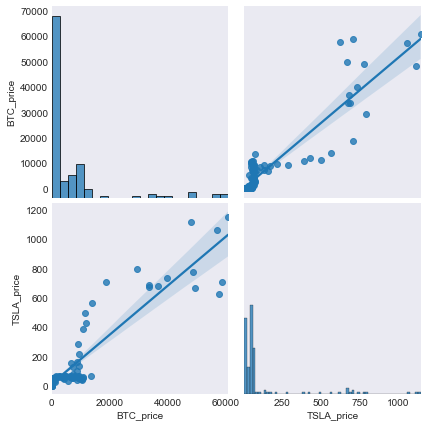

In [26]:
# análisis visual de la correlación entre las dos variables
sns.pairplot(df, height=3, kind='reg')
plt.show()

In [16]:
# escalamiento de los datos por medio de la técnica z-score
scaler = StandardScaler()
scaled = scaler.fit_transform(df[['BTC_price', 'TSLA_price']])

In [18]:
# cálculo de la matriz de covarianza
covariance_matrix = np.cov(scaled.T)
covariance_matrix

array([[1.00729927, 0.92955173],
       [0.92955173, 1.00729927]])

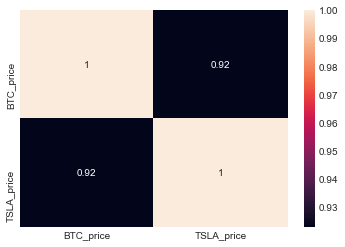

In [19]:
# visualización de los resultados de la matriz de covarianza
sns.heatmap(df.corr(), annot=True)
plt.show()

Dado que las variables no se distribuyen normalmente, se procede a realizar una transformación usando la tangente hiperbólica para, eventualmente, obtener una curva normal sobre los datos no lineales.

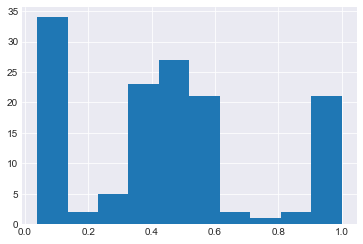

In [46]:
# transformacion con la tangente hiperbolica tanh(x)
p = 100
df.TSLA_price.apply(lambda x: np.tanh(x/p)).hist()
plt.show()

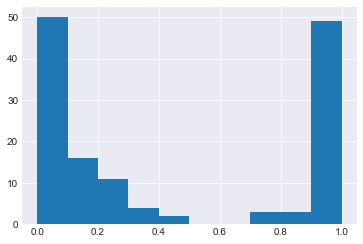

In [70]:
# transformacion con la tangente hiperbolica tanh(x)
p = 2800
df.BTC_price.apply(lambda x: np.tanh(x/p)).hist()
plt.show()

En ambos casos se observa que esta transformación no es posible, porque las nuevas distribuciones obtenidas no representan el comportamiento de una curva con distribución normal.

### 3. Conclusiones
* El análisis de la Matriz de Covarianza, nos podría llevar equivocadamente a deducir una fuerte correlación entre las variables. Pero, por otra parte, el análisis de las gráficas en la visualización 'pairplot' nos ofrecen una idea respecto a que los datos no se distribuyen normalmente, y por ende la aplicación del escalamiento 'z-score' no correspondía.
* Finalmente, al intentar normalizar estas variables mediante una transformación con la tangente hiperbólica, tampoco se pudo conseguir. 
* Cabe señalar que siempre debe someterse a escrutinio la correlación entre variables, indagando la naturaleza de cada una. 


Para cerrar, cito textual desde [Wikipedia](https://es.wikipedia.org/wiki/Relaci%C3%B3n_espuria):
> *En la práctica, se deben cumplir tres condiciones para poder concluir que X causa Y, directa o indirectamente:*
> - *X debe preceder a Y.*
> - *Si Y no ocurre entonces X no ocurre.*
> - *Y debe ocurrir cada vez que X ocurra.*
>
> *Las relaciones espurias a menudo pueden ser identificadas considerando que cualquiera de estas condiciones ha sido violada.*